In [1]:
import matplotlib.pyplot as plt
from BLEanalysis.synthetic import SignalDemo
from BLEanalysis.pathinference import Path_ProbabilityDensitiesToBee, Path_VectorsToBee
from BLEanalysis.kernels import ExponentiatedQuadraticKernel

demo = SignalDemo(sample_interval=300)
k = ExponentiatedQuadraticKernel(7.0,50.0)
path = Path_ProbabilityDensitiesToBee(demo.obstimes,demo.burst_observations,k,3.0,6)
path.run(200,learning_rate=2.0)#,just_optimise_means=True)

Standardising angles and times (shifting by 38.00 degrees)
Standardising angles and times (shifting by 38.00 degrees)
Optimising mean...
iteration    0:   23554.3
iteration   50:   19689.0
iteration  100:   19651.1
iteration  150:   19650.9
Optimising mean and covariance...
iteration    0:    6753.2
iteration   50:    3830.4
iteration  100:    3324.4
iteration  150:    2420.7


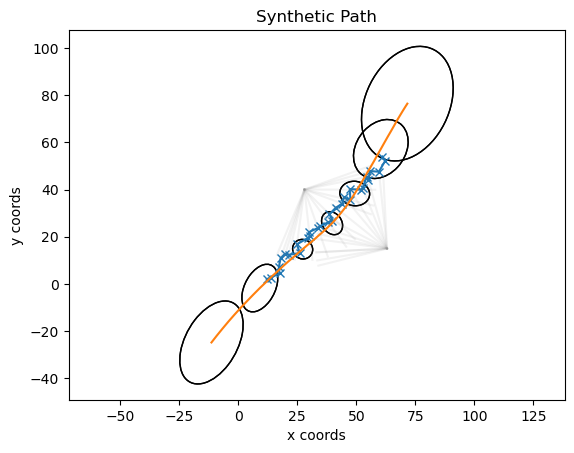

In [2]:
demo.plot()
path.plot(n_std=1)

## Comparison

As a quick comparison, here we find the mode of the angle distribution, and use that as a vector guess for inference, with the Path_VectorsToBee class: 

In [3]:
from BLEanalysis.angleinference import AnglesUsePatternMeans
angles = AnglesUsePatternMeans(noisevar=3**2)
import numpy as np
observations = []
for b in demo.burst_observations:
    logps,_,_,_ = angles.infer(b['rssis'],b['angles'])
    angle = np.linspace(0,np.pi*2,360)[np.argmax(logps)]
    obs = np.array([b['transmitter_position'][0],b['transmitter_position'][1],np.cos(angle),np.sin(angle)])
    observations.append(obs)
observations = np.array(observations)

Standardising angles and times (shifting by 38.00 degrees)


In [4]:
from BLEanalysis.pathinference import Path_VectorsToBee
path = Path_VectorsToBee(demo.obstimes,observations,k,6,0.1)
path.run(200,learning_rate=2.0)

Optimising mean...
iteration    0: 2785103.2
iteration   50:   49911.3
iteration  100:   39289.0
iteration  150:   35450.4
Optimising mean and covariance...
iteration    0:   68543.3
iteration   50:   15544.3
iteration  100:   14471.3
iteration  150:   14903.3


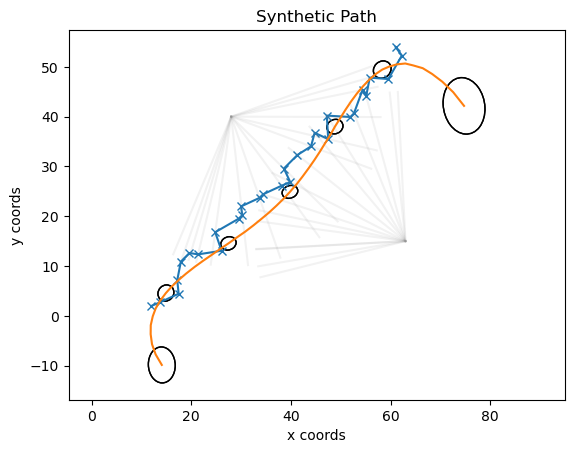

In [5]:
demo.plot()
path.plot(n_std=1)

# Note on the synthetic dataset

The observations consist of a list of dictionaries, each item contains:
 - the location of the transmitter
 - a list of RSSIs
 - a list of angles
TODO: A method in Signals should potentially generate this list from the data it has

In [6]:
x = 28
demo.burst_observations[x]

{'transmitter_position': array([28., 40.]),
 'rssis': array([-86., -83., -83., -77., -63., -80., -83., -80.]),
 'angles': array([ 2.43115762,  3.30382225,  4.24630005,  5.17132455, -0.18683625,
         0.70328166,  1.61085288,  2.53587738])}

To give an idea of the angle inference part of this, we will use the above data to infer the angle:

Standardising angles and times (shifting by 38.00 degrees)


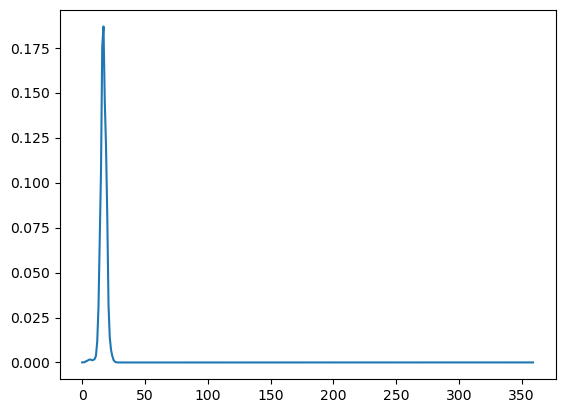

In [7]:
from BLEanalysis.angleinference import AnglesUsePatternMeans, normalise_logs_to_ps
angles = AnglesUsePatternMeans(noisevar=3**2)
import numpy as np
logps,_,_,_ = angles.infer(demo.burst_observations[x]['rssis'],demo.burst_observations[x]['angles'])
plt.plot(np.linspace(0,359,360),normalise_logs_to_ps(logps))

Trying out peak angle inference:

In [8]:
from BLEanalysis.angleinference import AnglesUsePeaks
angles = AnglesUsePeaks(100)
prediction = angles.infer(demo.burst_observations[x]['rssis'],demo.burst_observations[x]['angles'])
np.rad2deg(prediction)

C:\Users\chris\anaconda3\envs\newEnv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\chris\anaconda3\envs\newEnv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\chris\anaconda3\envs\newEnv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10.704928842741337

# Using Peak Signal Strengths

In [9]:
from BLEanalysis.angleinference import AnglesUsePeaks
demo = SignalDemo(sample_interval=150)
angles = AnglesUsePeaks(0)
observations = []
for b in demo.burst_observations:
    angle = angles.infer(b['rssis'],b['angles'])
    obs = np.array([b['transmitter_position'][0],b['transmitter_position'][1],np.cos(angle),np.sin(angle)])
    observations.append(obs)

Standardising angles and times (shifting by 38.00 degrees)


In [10]:
observationsRemoveNan = []
obstimesRemoveNan = []

for x in range(len(observations)):
    if not np.isnan(observations[x][2]):
        observationsRemoveNan.append(observations[x])
        obstimesRemoveNan.append(demo.obstimes[x])

In [11]:
from BLEanalysis.pathinference import Path_VectorsToBee
k = ExponentiatedQuadraticKernel(7.0,50.0)
path = Path_VectorsToBee(np.array(obstimesRemoveNan),np.array(observationsRemoveNan),k,6,0.1)
path.run(600,learning_rate=2.0)

Optimising mean...
iteration    0: 2768337.8
iteration   50:   88032.6
iteration  100:   75646.7
iteration  150:   70362.7
iteration  200:   67290.7
iteration  250:   65702.3
iteration  300:   64967.6
iteration  350:   64661.1
iteration  400:   64545.3
iteration  450:   64505.7
iteration  500:   64493.4
iteration  550:   64489.9
Optimising mean and covariance...
iteration    0:   97021.8
iteration   50:   48496.3
iteration  100:   47190.7
iteration  150:   46791.1
iteration  200:   48415.0
iteration  250:   45842.4
iteration  300:   46488.1
iteration  350:   46109.7
iteration  400:   46085.2
iteration  450:   45181.6
iteration  500:   44951.3
iteration  550:   76386.9


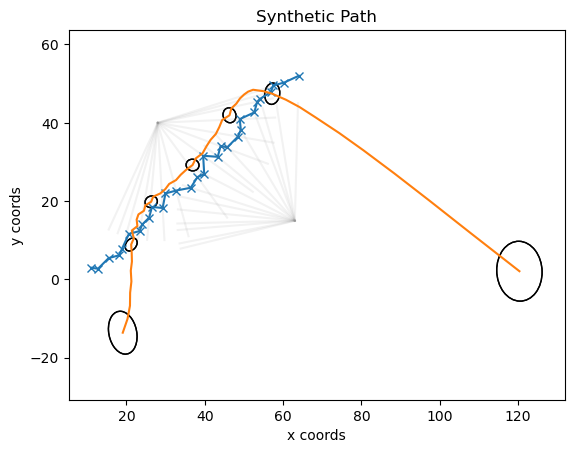

In [12]:
demo.plot()
path.plot(n_std=1)